In [3]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
#from netCDF4 import Dataset 
#%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
import sys, os
import numpy
import scipy
from scipy import signal

import warnings
import math
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
#from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb # tig4.1
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.models import LinearMediation, Prediction
from tigramite.models import Models
from tigramite.toymodels import structural_causal_processes as toys

import iris
import iris.coord_categorisation as coord_cat
import pandas as pd
import xarray as xr

from dask.diagnostics import ProgressBar

ModuleNotFoundError: No module named 'iris'

# Data loading

In [4]:
NAO_data = pd.read_excel("C:/Users/alexp/como/Precursors/NAO_daily.xlsx")
AO_data = pd.read_excel("C:/Users/alexp/como/Precursors/AO_daily.xlsx")
PNA_data = pd.read_excel("C:/Users/alexp/como/Precursors/PNA_daily.xlsx")
MOI_data = pd.read_excel("C:/Users/alexp/como/Precursors/MOI.xlsx")
MJO_data = pd.read_excel("C:/Users/alexp/como/Precursors/mjo.xlsx")

# Fix Dates 

In [5]:
# Create datetime index for each dataset
NAO_data['Date'] = pd.to_datetime(NAO_data[['Year', 'Month', 'Day']])
AO_data['Date'] = pd.to_datetime(AO_data[['Year', 'Month', 'Day']])
PNA_data['Date'] = pd.to_datetime(PNA_data[['Year', 'Month', 'Day']])
MOI_data['Date'] = pd.to_datetime(MOI_data[['Year', 'Month', 'Day']])
MJO_data['Date'] = pd.to_datetime(MJO_data[['year', 'month', 'day']])

# Set the 'Date' column as the index
NAO_data.set_index('Date', inplace=True)
AO_data.set_index('Date', inplace=True)
PNA_data.set_index('Date', inplace=True)
MOI_data.set_index('Date', inplace=True)
MJO_data.set_index('Date', inplace=True)

# Filter data for the period between 1981-01-01 and 2022-12-31
start_date = '1981-01-01'
end_date = '2022-12-31'

NAO_data = NAO_data.loc[start_date:end_date]
AO_data = AO_data.loc[start_date:end_date]
PNA_data = PNA_data.loc[start_date:end_date]
MOI_data = MOI_data.loc[start_date:end_date]
MJO_data = MJO_data.loc[start_date:end_date]

# Extract the relevant columns
NAO = NAO_data['NAO']
AO = AO_data['AO']
PNA = PNA_data['PNA']
MOI = MOI_data['MOI']
MJO = MJO_data['amplitude']

In [6]:
# Display the first few rows of each to confirm
print(NAO.head())
print(AO.head())
print(PNA.head())
print(MOI.head())
print(MJO.tail())

Date
1981-01-01    0.906
1981-01-02    0.781
1981-01-03    0.414
1981-01-04    0.259
1981-01-05    0.279
Name: NAO, dtype: float64
Date
1981-01-01   -0.272
1981-01-02   -0.585
1981-01-03   -1.284
1981-01-04   -1.598
1981-01-05   -1.802
Name: AO, dtype: float64
Date
1981-01-01    1.015
1981-01-02    0.881
1981-01-03    0.760
1981-01-04    0.952
1981-01-05    1.041
Name: PNA, dtype: float64
Date
1981-01-01    2.229
1981-01-02    3.157
1981-01-03    2.780
1981-01-04    1.304
1981-01-05    0.583
Name: MOI, dtype: float64
Date
2022-12-27    1.605746
2022-12-28    1.538229
2022-12-29    1.584863
2022-12-30    1.651366
2022-12-31    1.591281
Name: amplitude, dtype: float64


# Resample to 7-day

In [7]:
startyear=1981
endyear=2022

NAO_weekly = pd.concat([NAO[NAO.index.year==year].resample('7D',origin='start').mean() for year in range(startyear,endyear+1)])
AO_weekly = pd.concat([AO[AO.index.year==year].resample('7D',origin='start').mean() for year in range(startyear,endyear+1)])
PNA_weekly = pd.concat([PNA[PNA.index.year==year].resample('7D',origin='start').mean() for year in range(startyear,endyear+1)])
MOI_weekly = pd.concat([MOI[MOI.index.year==year].resample('7D',origin='start').mean() for year in range(startyear,endyear+1)])
MJO_weekly = pd.concat([MJO[MJO.index.year==year].resample('7D',origin='start').mean() for year in range(startyear,endyear+1)])


# Load SCHDI index data

In [28]:
SCHDI_data = pd.read_excel("C:/Users/alexp/como/SCDHI_balkans.xlsx")

In [29]:
# Parse the 'dates' column to datetime format
SCHDI_data['dates'] = pd.to_datetime(SCHDI_data['dates'], format='%d/%m/%Y')

# Set the 'dates' column as the index
SCHDI_data.set_index('dates', inplace=True)

SCHDI_data = SCHDI_data.loc[start_date:end_date]
# Extract the relevant columns
SCHDI = -SCHDI_data['SCDHI']

In [30]:
print(SCHDI.tail())


dates
2022-12-03    0.966481
2022-12-10    1.477371
2022-12-17    0.940169
2022-12-24    1.292706
2022-12-31    2.307037
Name: SCDHI, dtype: float64


# Detrending and Calculating Anomalies

In [11]:
# Define the time cycle and number of years
n_years= 42
time_cycle =52


In [12]:
# detrend
for j in range(time_cycle):
    NAO_weekly[j::time_cycle] = scipy.signal.detrend(NAO_weekly[j::time_cycle], axis = 0) 
    AO_weekly[j::time_cycle] = scipy.signal.detrend(AO_weekly[j::time_cycle], axis = 0) 
    MOI_weekly[j::time_cycle] = scipy.signal.detrend(MOI_weekly[j::time_cycle], axis = 0)
    PNA_weekly[j::time_cycle] = scipy.signal.detrend(PNA_weekly[j::time_cycle], axis = 0)
    MJO_weekly[j::time_cycle] = scipy.signal.detrend(MJO_weekly[j::time_cycle], axis = 0)
    SCHDI[j::time_cycle] = scipy.signal.detrend(SCHDI[j::time_cycle], axis = 0)

C:\Users\alexp\AppData\Local\Temp\ipykernel_8612\1557222103.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SCHDI[j::time_cycle] = scipy.signal.detrend(SCHDI[j::time_cycle], axis = 0)
C:\Users\alexp\AppData\Local\Temp\ipykernel_8612\1557222103.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SCHDI[j::time_cycle] = scipy.signal.detrend(SCHDI[j::time_cycle], axis = 0)
C:\Users\alexp\AppData\Local\Temp\ipykernel_8612\1557222103.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [13]:
#calculate anomalies
for i in range(int(time_cycle)):
    NAO_weekly[i::int(time_cycle)]    = (NAO_weekly[i::int(time_cycle)]    - np.mean(NAO_weekly[:int(time_cycle*n_years)][i::int(time_cycle)], axis = 0))
    AO_weekly[i::int(time_cycle)]   = (AO_weekly[i::int(time_cycle)]   - np.mean(AO_weekly[:int(time_cycle*n_years)][i::int(time_cycle)], axis = 0))
    MOI_weekly[i::int(time_cycle)]    = (MOI_weekly[i::int(time_cycle)]    - np.mean(MOI_weekly[:int(time_cycle*n_years)][i::int(time_cycle)], axis = 0))
    PNA_weekly[i::int(time_cycle)]   = (PNA_weekly[i::int(time_cycle)]   - np.mean(PNA_weekly[:int(time_cycle*n_years)][i::int(time_cycle)], axis = 0))
    MJO_weekly[i::int(time_cycle)]   = (MJO_weekly[i::int(time_cycle)]   - np.mean(MJO_weekly[:int(time_cycle*n_years)][i::int(time_cycle)], axis = 0))
    SCHDI[i::int(time_cycle)]   = (SCHDI[i::int(time_cycle)]   - np.mean(SCHDI[:int(time_cycle*n_years)][i::int(time_cycle)], axis = 0))

C:\Users\alexp\AppData\Local\Temp\ipykernel_8612\3764043902.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SCHDI[i::int(time_cycle)]   = (SCHDI[i::int(time_cycle)]   - np.mean(SCHDI[:int(time_cycle*n_years)][i::int(time_cycle)], axis = 0))
C:\Users\alexp\AppData\Local\Temp\ipykernel_8612\3764043902.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SCHDI[i::int(time_cycle)]   = (SCHDI[i::int(time_cycle)]   - np.mean(SCHDI[:int(time_cycle*n_years)][i::int(time_cycle)], axis = 0))
C:\Users\alexp\AppData\Local\Temp\ipykernel_8612\3764043902.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

# Create the final array for the analysis

In [14]:
# Stack the data to create the final array for analysis
fulldata = np.vstack((
                      SCHDI/np.std(SCHDI), 
                      NAO_weekly/np.std(NAO_weekly),
                      AO_weekly/np.std(AO_weekly),
                      MOI_weekly/np.std(MOI_weekly),
                      PNA_weekly/np.std(PNA_weekly),
                      MJO_weekly/np.std(MJO_weekly))).T

var_names = [
    'SCHDI',
    'NAO',
    'AO',
    'MOI',
    'PNA',
    'MJO']

In [15]:
# Check the start and end dates of each dataset
print(SCHDI)
print(NAO_weekly)
print(AO_weekly)
print(MOI_weekly)
print(PNA_weekly)
print(MJO_weekly)


dates
1981-01-01    0.733339
1981-01-08    0.840154
1981-01-15    0.720728
1981-01-22    1.165603
1981-01-29    0.587516
                ...   
2022-12-03   -0.269488
2022-12-10   -1.048133
2022-12-17   -0.185855
2022-12-24   -0.245155
2022-12-31   -1.023936
Name: SCDHI, Length: 2226, dtype: float64
Date
1981-01-01    0.511662
1981-01-08   -0.107966
1981-01-15   -0.000100
1981-01-22   -0.045034
1981-01-29    0.404772
                ...   
2022-12-03   -1.488352
2022-12-10   -0.798255
2022-12-17   -0.514696
2022-12-24    0.495262
2022-12-31    0.795096
Name: NAO, Length: 2226, dtype: float64
Date
1981-01-01   -0.572035
1981-01-08   -0.434985
1981-01-15   -0.668996
1981-01-22    0.568693
1981-01-29    2.270441
                ...   
2022-12-03   -2.280538
2022-12-10   -3.419584
2022-12-17   -3.247615
2022-12-24   -1.654252
2022-12-31   -0.059481
Name: AO, Length: 2226, dtype: float64
Date
1981-01-01    1.909269
1981-01-08   -0.414982
1981-01-15    1.494558
1981-01-22    0.896028
1981-01

# Create seasonal mask ()

In [16]:
# Get the weekly date range to match the resampled data
weekly_date_range = NAO_weekly.index

# Create seasonal masks for the weekly data
jja_mask = ((weekly_date_range.month == 6) | (weekly_date_range.month == 7) | (weekly_date_range.month == 8))

# Combine masks if needed (example: mask data for NDJ season)
data_mask = np.ones(fulldata.shape, dtype=bool)
data_mask[jja_mask, :] = False   #Here we choose the mask

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


(<Figure size 1000x500 with 6 Axes>,
 array([<Axes: ylabel='SCHDI'>, <Axes: ylabel='NAO'>, <Axes: ylabel='AO'>,
        <Axes: ylabel='MOI'>, <Axes: ylabel='PNA'>, <Axes: ylabel='MJO'>],
       dtype=object))

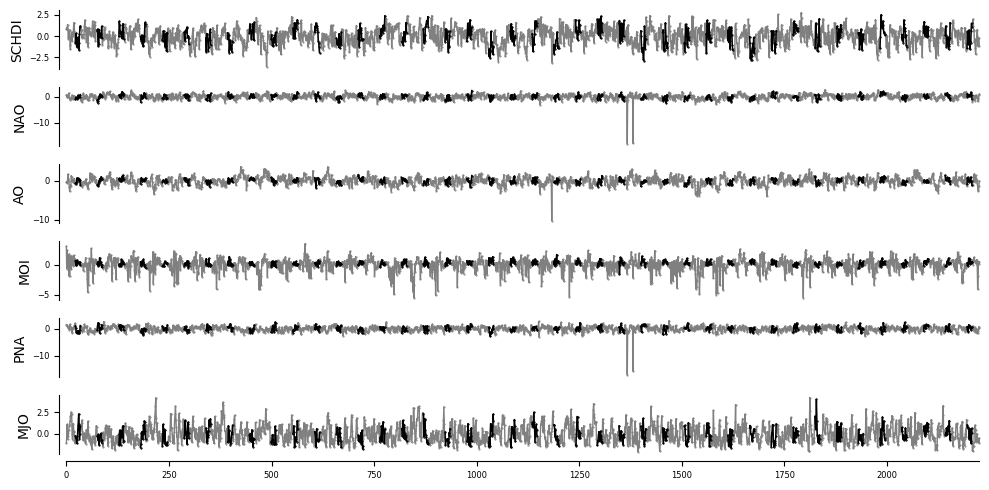

In [17]:
print(data_mask[:52, 0])  # Print to verify the first 52 weeks of the mask


# Initialize dataframe object (needed for tigramite functions)
dataframe = pp.DataFrame(fulldata, datatime=np.arange(len(fulldata)), var_names=var_names, mask=data_mask)

# Plot the time series to verify that masking is correct
tp.plot_timeseries(dataframe, figsize=(10, 5), grey_masked_samples='data')


<Axes: xlabel='Date'>

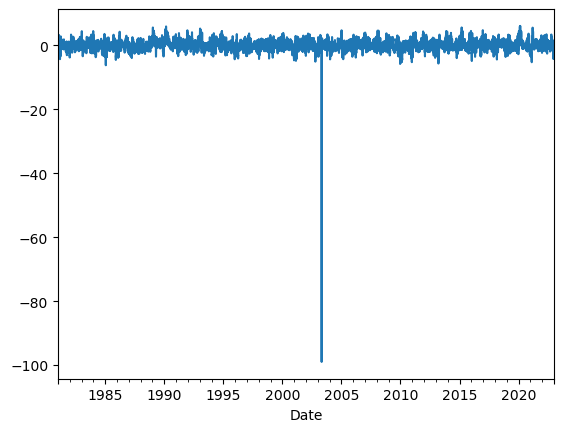

In [24]:
NAO

# PCMCI

In [31]:

##### PCMCI
parcorr = ParCorr(significance='analytic', 
                  mask_type='y', 
                  verbosity=4)

pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    #selected_variables=None,
    verbosity=4)

#results = pcmci.run_pc_stable(tau_max=6, pc_alpha=0.05)
tau_min = 1
tau_max = 4
results = pcmci.run_pcmci(tau_max=tau_max,tau_min=tau_min, pc_alpha = None)#[0.001, 0.01,0.05, 0.1, 0.2])#None)
# put also tau_min if you need

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
alpha_level_v = 0.05

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
         
    
        val_matrix = results['val_matrix'],
        alpha_level = alpha_level_v)

graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.05,
            tau_min=tau_min, tau_max=tau_max, 
           #selected_links=None
            )
results['graph'] = graph 


# Initialize conditional independence test

Parameters:
independence test = par_corr
significance = analytic
mask_type = y

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 4
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Variable SCHDI

Iterating through pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:

# pc_alpha = 0.05 (1/6):

Testing condition sets of dimension 0:

    Link (SCHDI -1) -?> SCHDI (1/24):
            Constructed array of shape (2, 546) from
            X = [(0, -1)]
            Y = [(0, 0)]
            Z = []
            extraZ = []
            with masked samples in y removed
        val =  0.552 | pval = 0.00000 | dependent = True 
    Subset 0: () gives pval = 0.00000 / val =  0.552
    No conditions of dimension 0 left.

    Link (SCHDI -2) -?> SCHDI (2/24):
            Constructed array of shape (2, 546) from
            X = [(0, -2)]
            

In [32]:
all_parents = pcmci.return_parents_dict(graph, val_matrix=results['val_matrix'], include_lagzero_parents=False)
print(all_parents)
link_matrix = graph
#link_matrix = sig['link_matrix']
med = LinearMediation(dataframe=dataframe,            

            mask_type = 'y',
            data_transform = None)
med.fit_model(all_parents = all_parents, tau_max=tau_max)             
Links = med.get_val_matrix()
pcmci.print_significant_links(
        p_matrix = q_matrix, 
        #q_matrix = q_matrix,
    
        val_matrix = Links,
        alpha_level = alpha_level_v)


{0: [(0, -1), (1, -1), (3, -1)], 1: [(1, -1), (1, -2), (2, -1)], 2: [(2, -1)], 3: [(0, -1), (3, -3), (3, -1)], 4: [(4, -1), (3, -1)], 5: [(5, -1), (5, -2)]}

## Significant links at alpha = 0.05:

    Variable SCHDI has 3 link(s):
        (SCHDI -1): pval = 0.00000 | val =  0.562
        (MOI -1): pval = 0.01053 | val =  0.265
        (NAO -1): pval = 0.00002 | val =  0.217

    Variable NAO has 3 link(s):
        (NAO -1): pval = 0.00000 | val =  0.495
        (AO -1): pval = 0.04845 | val =  0.165
        (NAO -2): pval = 0.00612 | val = -0.095

    Variable AO has 1 link(s):
        (AO -1): pval = 0.00000 | val =  0.479

    Variable MOI has 3 link(s):
        (MOI -1): pval = 0.01789 | val =  0.155
        (MOI -3): pval = 0.00977 | val =  0.131
        (SCHDI -1): pval = 0.00099 | val = -0.049

    Variable PNA has 2 link(s):
        (PNA -1): pval = 0.00000 | val =  0.469
        (MOI -1): pval = 0.01889 | val =  0.268

    Variable MJO has 2 link(s):
        (MJO -1): pval = 0.

(<Figure size 600x400 with 1 Axes>, <Axes: >)

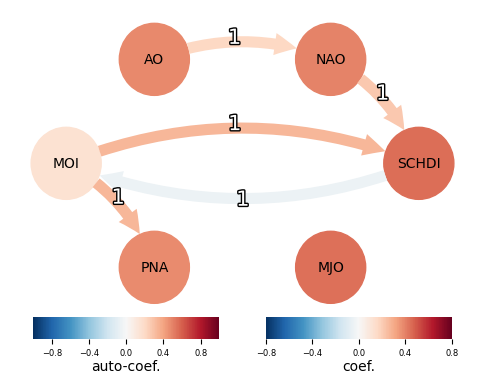

In [33]:
# Plot graph with link color given by linear regression coefficients
val_matrix = med.get_val_matrix()
#print(val_matrix)
tp.plot_graph(
    val_matrix=val_matrix,
    #link_matrix=link_matrix,
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='coef.',
    node_colorbar_label='auto-coef.',
    
    figsize = [6,4],
    vmin_edges = -0.8,
    vmax_edges = 0.8,
    #vmin_nodes = -1.0,
    #vmax_nodes = 1.,
    node_size  =0.6,
    #arrow_linewidth  = 12,
    #arrowhead_size = 20,
    #cmap_nodes = 'RdBu_r',
    #edge_ticks = 0.2,
    #node_ticks = 0.25,
    #alpha = 1,
    #node_pos = {'x':(0.9,0.5,0.1,0.9,0.7,0.5), 'y':(0.7,1,0.7,0.0,0.25,0.5)},#node_pos  = None,
    #[  'MT rain', 'NAO', 'CGTI', 'EOF2', 'EOF1']
    #node_pos = {'x':(0.5,0.3, 0.7), 'y':(0.2,0.65, 1)},#node_pos  = None,
    #[  'MT rain', 'CGTI', 'EOF2']
    node_label_size = 10,
    link_label_fontsize  = 15,
     )
